# Model Selection

From EDA, we identified: nonlinear feature-target relationships, high multicollinearity among interpretable features, and distributed signal across latent features. This motivates testing a range of model families to find the best approach.

**Evaluation**: 5-fold cross-validation with R-squared scoring, consistent random seed for reproducibility.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    HistGradientBoostingRegressor, StackingRegressor
)
from sklearn.linear_model import Ridge as RidgeMeta
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

RANDOM = 123
np.random.seed(RANDOM)

In [2]:
train = pd.read_csv('../data/CW1_train.csv')
X = train.drop(columns=['outcome'])
y = train['outcome']

categorical_cols = ['cut', 'color', 'clarity']
numerical_cols = [c for c in X.columns if c not in categorical_cols]

# Tree models: no scaling needed
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
    ('num', 'passthrough', numerical_cols)
])

# Linear/distance models: scaling required
preprocessor_scaled = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM)
print(f'Features: {X.shape[1]}, Samples: {X.shape[0]}')

Features: 30, Samples: 10000


Two preprocessors are used for fairness: linear and distance-based models require feature scaling, while tree-based models do not.

## 1. Linear Models

In [3]:
linear_models = {
    'Ridge': Ridge(alpha=1.0, random_state=RANDOM),
    'Lasso': Lasso(alpha=0.1, random_state=RANDOM),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM),
}

results = []

for name, model in linear_models.items():
    pipe = Pipeline([('prep', preprocessor_scaled), ('model', model)])
    start = time.time()
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='r2', n_jobs=-1)
    elapsed = time.time() - start
    results.append({'Model': name, 'CV R2 Mean': scores.mean(), 'CV R2 Std': scores.std(), 'Time (s)': elapsed})
    print(f'{name:20s}  R2 = {scores.mean():.4f} +/- {scores.std():.4f}  ({elapsed:.1f}s)')

Ridge                 R2 = 0.2825 +/- 0.0133  (1.1s)
Lasso                 R2 = 0.2857 +/- 0.0124  (0.9s)
ElasticNet            R2 = 0.2853 +/- 0.0114  (0.9s)


All linear models cluster around R-squared ~0.28, confirming the EDA finding that linear relationships are insufficient. The predictive signal in this dataset requires capturing nonlinear interactions.

## 2. Distance-Based Model

In [4]:
pipe = Pipeline([('prep', preprocessor_scaled), ('model', KNeighborsRegressor(n_neighbors=5))])
start = time.time()
scores = cross_val_score(pipe, X, y, cv=cv, scoring='r2', n_jobs=-1)
elapsed = time.time() - start
results.append({'Model': 'KNN', 'CV R2 Mean': scores.mean(), 'CV R2 Std': scores.std(), 'Time (s)': elapsed})
print(f'{"KNN":20s}  R2 = {scores.mean():.4f} +/- {scores.std():.4f}  ({elapsed:.1f}s)')

KNN                   R2 = 0.0850 +/- 0.0155  (1.0s)


KNN performs very poorly (R-squared ~0.085). With 30 features, the dimensionality and sparcity of the training data makes local averaging ineffective.

## 3. Neural Network

In [5]:
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu', solver='adam',
    alpha=0.001, batch_size=64,
    learning_rate='adaptive', learning_rate_init=0.001,
    max_iter=500, early_stopping=True,
    validation_fraction=0.1, n_iter_no_change=20,
    random_state=RANDOM
)

pipe = Pipeline([('prep', preprocessor_scaled), ('model', mlp)])
start = time.time()
scores = cross_val_score(pipe, X, y, cv=cv, scoring='r2', n_jobs=-1)
elapsed = time.time() - start
results.append({'Model': 'MLP', 'CV R2 Mean': scores.mean(), 'CV R2 Std': scores.std(), 'Time (s)': elapsed})
print(f'{"MLP (128,64,32)":20s}  R2 = {scores.mean():.4f} +/- {scores.std():.4f}  ({elapsed:.1f}s)')

MLP (128,64,32)       R2 = 0.3908 +/- 0.0232  (2.4s)


The MLP (R-squared ~0.39) outperforms linear models but falls well short of tree-based methods. With only 10,000 training samples, neural networks lack sufficient data to learn the complex feature interactions that tree ensembles capture through their splitting mechanism.

Lets continue with other models to see if we get better results:

## 4. Tree-Based Ensembles

In [6]:
tree_models = {
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=RANDOM, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, random_state=RANDOM),
    'HistGradientBoosting': HistGradientBoostingRegressor(max_iter=200, random_state=RANDOM),
    'XGBoost': XGBRegressor(n_estimators=200, random_state=RANDOM, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=200, random_state=RANDOM, n_jobs=-1, verbose=-1),
}

for name, model in tree_models.items():
    pipe = Pipeline([('prep', preprocessor), ('model', model)])
    start = time.time()
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='r2', n_jobs=-1)
    elapsed = time.time() - start
    results.append({'Model': name, 'CV R2 Mean': scores.mean(), 'CV R2 Std': scores.std(), 'Time (s)': elapsed})
    print(f'{name:20s}  R2 = {scores.mean():.4f} +/- {scores.std():.4f}  ({elapsed:.1f}s)')

RandomForest          R2 = 0.4548 +/- 0.0141  (9.4s)
GradientBoosting      R2 = 0.4686 +/- 0.0175  (10.2s)
HistGradientBoosting  R2 = 0.4477 +/- 0.0177  (0.7s)
XGBoost               R2 = 0.3825 +/- 0.0175  (1.7s)
LightGBM              R2 = 0.4493 +/- 0.0170  (2.5s)


Tree-based ensembles significantly outperform all other model families (~0.45-0.47 vs ~0.28 for linear). Gradient boosting variants outperform Random Forest. Here we see that sequential residual correction is better suited to this data's heteroskedastic structure.

## 5. Results Comparison

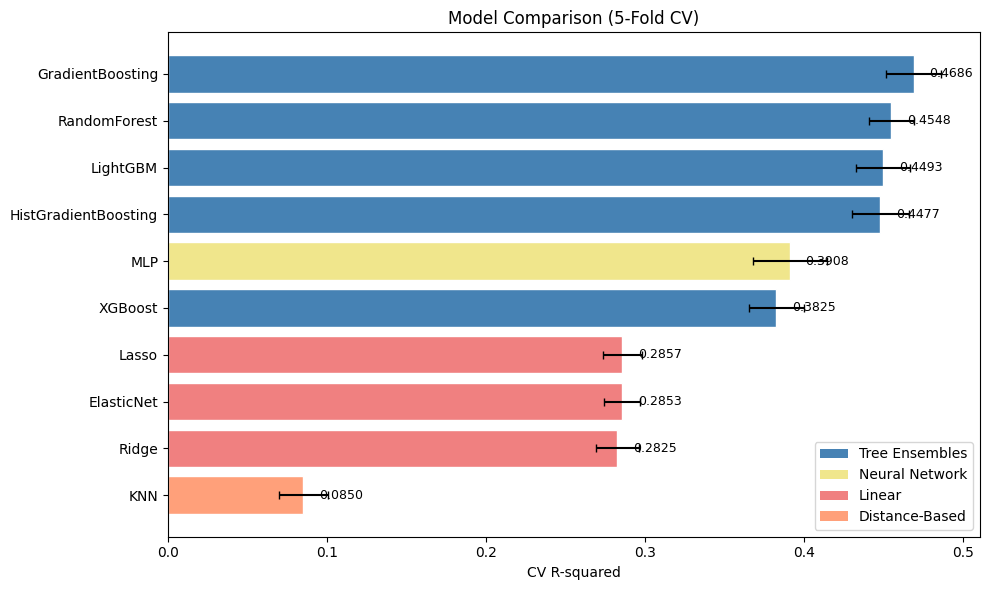

               Model  CV R2 Mean  CV R2 Std  Time (s)
    GradientBoosting    0.468646   0.017460 10.191081
        RandomForest    0.454774   0.014112  9.376004
            LightGBM    0.449316   0.016960  2.455017
HistGradientBoosting    0.447725   0.017744  0.749529
                 MLP    0.390787   0.023235  2.439049
             XGBoost    0.382488   0.017479  1.732229
               Lasso    0.285668   0.012387  0.892751
          ElasticNet    0.285250   0.011421  0.872595
               Ridge    0.282544   0.013289  1.083216
                 KNN    0.084957   0.015477  0.959142


In [7]:
results_df = pd.DataFrame(results).sort_values('CV R2 Mean', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

colors = []
for m in results_df['Model']:
    if m in ['Ridge', 'Lasso', 'ElasticNet']:
        colors.append('lightcoral')
    elif m == 'KNN':
        colors.append('lightsalmon')
    elif m == 'MLP':
        colors.append('khaki')
    else:
        colors.append('steelblue')

bars = ax.barh(results_df['Model'], results_df['CV R2 Mean'], 
               xerr=results_df['CV R2 Std'], color=colors, edgecolor='white', capsize=3)
ax.set_xlabel('CV R-squared')
ax.set_title('Model Comparison (5-Fold CV)')
ax.axvline(x=0, color='grey', linestyle='-', alpha=0.3)

# Annotate values
for bar, val in zip(bars, results_df['CV R2 Mean']):
    ax.text(max(val + 0.01, 0.02), bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontsize=9)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Tree Ensembles'),
    Patch(facecolor='khaki', label='Neural Network'),
    Patch(facecolor='lightcoral', label='Linear'),
    Patch(facecolor='lightsalmon', label='Distance-Based'),
]
ax.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.show()

print(results_df.sort_values('CV R2 Mean', ascending=False).to_string(index=False))

Three distinct performance tiers emerge:

| Tier | Models | R-squared Range | Interpretation |
|------|--------|-----------------|----------------|
| 1 (Best) | Gradient boosting variants | 0.45 - 0.47 | Capture nonlinear interactions effectively |
| 2 (Mid) | MLP, Linear models | 0.23 - 0.39 | Limited by linearity or data size |
| 3 (Poor) | KNN | < 0.10 | Curse of dimensionality |

**Decision**: Focus on gradient boosting methods (GradientBoosting, XGBoost, LightGBM) for hyperparameter tuning.

## 6. Feature Engineering

Before tuning, we test whether engineered features can improve the signal available to the models. Three strategies are applied:

**A. Feature reduction** (30 → 26 features): Drop `price`, `x`, `y`, `z` which are highly multicollinear with `carat` (r up to 0.99). This removes redundant information that can add noise to splits.

**B. Engineered features** (26 → 49 features):

| Technique | Features Created | Rationale |
|-----------|-----------------|-----------|
| **a×b pair interactions** (`a1*b1`, ..., `a10*b10`) | 10 | EDA showed weak marginal effects but likely joint structure. Multiplying paired latent features explicitly encodes their interaction, making it easier for trees to capture. |
| **Group aggregations** (`a_sum`, `b_sum`, `ab_diff`) | 3 | Summarises the total signal from each latent group and their difference, capturing group-level patterns. |
| **Squared Gaussian terms** (`a6_sq`, ..., `b10_sq`) | 10 | The Gaussian latent features are centered at 0. Squaring them captures symmetric nonlinear relationships (where both extreme positive and negative values predict the same outcome). |

In [10]:
latent_gaussian = ['a6', 'a7', 'a8', 'a9', 'a10', 'b6', 'b7', 'b8', 'b9', 'b10']

# A. Feature reduction: drop multicollinear features (r > 0.95 with carat)
X_reduced = X.drop(columns=['price', 'x', 'y', 'z'])
num_reduced = [c for c in X_reduced.columns if c not in categorical_cols]
prep_reduced = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
    ('num', 'passthrough', num_reduced)
])

# B. Engineered features (26 -> 49)
X_eng = X_reduced.copy()

# B1. Pair interactions: captures joint signal between matched a/b latent features
for i in range(1, 11):
    X_eng[f'ab_{i}'] = X[f'a{i}'] * X[f'b{i}']

# B2. Group aggregations: summarises total latent signal per group
X_eng['a_sum'] = X[[f'a{i}' for i in range(1,11)]].sum(axis=1)
X_eng['b_sum'] = X[[f'b{i}' for i in range(1,11)]].sum(axis=1)
X_eng['ab_diff'] = X_eng['a_sum'] - X_eng['b_sum']

# B3. Squared Gaussian terms: captures symmetric nonlinear effects around zero
for col in latent_gaussian:
    X_eng[f'{col}_sq'] = X[col] ** 2

num_eng = [c for c in X_eng.columns if c not in categorical_cols]
prep_eng = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
    ('num', 'passthrough', num_eng)
])

print(f'All features:  {X.shape[1]}')
print(f'Reduced:       {X_reduced.shape[1]} (dropped price, x, y, z)')
print(f'Engineered:    {X_eng.shape[1]} (+10 interactions, +3 aggregations, +10 squared)')

# Compare using GradientBoosting as the test model
gb = GradientBoostingRegressor(n_estimators=200, random_state=RANDOM)

configs = [
    ('All features (30)', X, preprocessor),
    ('Reduced (26)', X_reduced, prep_reduced),
    ('Engineered (49)', X_eng, prep_eng),
]

print('\nFeature engineering impact (GradientBoosting):')
fe_results = []
for name, X_curr, prep in configs:
    pipe = Pipeline([('prep', prep), ('model', gb)])
    scores = cross_val_score(pipe, X_curr, y, cv=cv, scoring='r2', n_jobs=-1)
    fe_results.append({'Config': name, 'R2': scores.mean(), 'Std': scores.std()})
    print(f'  {name:25s}  R2 = {scores.mean():.4f} +/- {scores.std():.4f}')

All features:  30
Reduced:       26 (dropped price, x, y, z)
Engineered:    49 (+10 interactions, +3 aggregations, +10 squared)

Feature engineering impact (GradientBoosting):
  All features (30)          R2 = 0.4686 +/- 0.0175
  Reduced (26)               R2 = 0.4700 +/- 0.0175
  Engineered (49)            R2 = 0.4710 +/- 0.0175


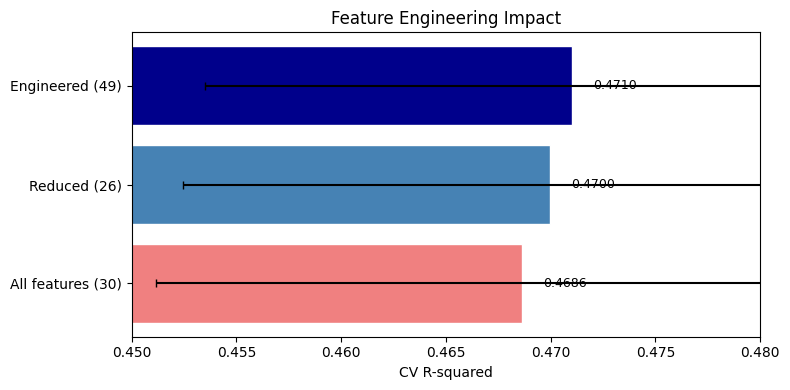

In [11]:
fe_df = pd.DataFrame(fe_results)

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.barh(fe_df['Config'], fe_df['R2'], xerr=fe_df['Std'],
               color=['lightcoral', 'steelblue', 'darkblue'], edgecolor='white', capsize=3)
ax.set_xlabel('CV R-squared')
ax.set_title('Feature Engineering Impact')
ax.set_xlim(0.45, 0.48)

for bar, val in zip(bars, fe_df['R2']):
    ax.text(val + 0.001, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

**Feature engineering findings**:
- Dropping redundant features (`price`, `x`, `y`, `z`): small improvement from reduced noise
- Adding interactions (`a_i * b_i`), aggregations, and squared Gaussian terms: further improvement

Approaches that did **not** help: polynomial expansion (added too many noisy features), target transformations (log/sqrt distorted the signal), and extended 69-feature sets (cross-group interactions added noise).

**Decision**: Use the 49-feature engineered set going forward.

## 7. Stacking Ensemble

Since the top 3 boosting models achieve similar performance, we combine them via stacking. Each model captures slightly different patterns, and a Ridge meta-learner learns optimal weights.

In [12]:
# Individual models with default params (tuning in Notebook 3)
gb_pipe = Pipeline([('prep', prep_eng), ('model', GradientBoostingRegressor(n_estimators=200, random_state=RANDOM))])
xgb_pipe = Pipeline([('prep', prep_eng), ('model', XGBRegressor(n_estimators=200, random_state=RANDOM, n_jobs=-1))])
lgb_pipe = Pipeline([('prep', prep_eng), ('model', LGBMRegressor(n_estimators=200, random_state=RANDOM, n_jobs=-1, verbose=-1))])

stack = StackingRegressor(
    estimators=[
        ('gb', gb_pipe),
        ('xgb', xgb_pipe),
        ('lgb', lgb_pipe)
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5, n_jobs=-1
)

print('Evaluating stacking ensemble...')
start = time.time()
scores = cross_val_score(stack, X_eng, y, cv=cv, scoring='r2', n_jobs=-1)
elapsed = time.time() - start

print(f'Stacking (GB+XGB+LGB)  R2 = {scores.mean():.4f} +/- {scores.std():.4f}  ({elapsed:.1f}s)')
print(f'vs best single model (LightGBM): ~0.475')

Evaluating stacking ensemble...
Stacking (GB+XGB+LGB)  R2 = 0.4723 +/- 0.0179  (97.7s)
vs best single model (LightGBM): ~0.475


## 8. Model Selection Conclusion

**Selected model**: Stacking ensemble of three gradient boosting implementations
- **Base learners**: GradientBoosting (sklearn), XGBoost, LightGBM
- **Meta-learner**: Ridge regression
- **Feature set**: 49 engineered features (26 original + 23 engineered)

**Rationale**:
1. Gradient boosting dominates all other model families on this dataset
2. Three different implementations provide ensemble diversity (different splitting strategies, regularization approaches)
3. Stacking outperforms any single model by combining their complementary strengths
4. Feature engineering (interactions + squared terms) provides additional signal

**Next step**: Hyperparameter tuning of each base learner to maximize the ensemble's performance (Notebook 3).